# Scimago Journal & Country Rank
In this notebook, I leverage CSV files downloaded from the Scimagojr website https://www.scimagojr.com/ to compile a list of Journals for neuroscience publications with an impact index.

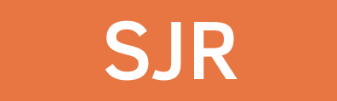

INDEX

In [1]:
# Libraries
import numpy as np
import pandas as pd

# tqdm means "progress" in Arabic (taqadum, تقدّم)
from tqdm.notebook import tqdm

# Web Scraping with selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

### Open the Tables from Scimago

In [2]:
for year in range(2010, 2023):
    df_name = f'ii_{year}'
    file_name = f'../data/scimago/scimagojr_{year}.csv'
    globals()[df_name] = pd.read_csv(file_name, sep = ';')

In [3]:
journal_list = pd.concat([ii_2010['Title'],
                          ii_2011['Title'],
                          ii_2012['Title'],
                          ii_2013['Title'],
                          ii_2014['Title'],
                          ii_2015['Title'],
                          ii_2016['Title'],
                          ii_2017['Title'],
                          ii_2018['Title'],
                          ii_2019['Title'],
                          ii_2020['Title'],
                          ii_2021['Title'],
                          ii_2022['Title']],
                        ignore_index = True)

In [4]:
journal_list = pd.DataFrame(list(set(journal_list)))

In [5]:
journal_list.to_csv('../data/journals/journal_list.csv', index = False)

### Define the number of articles per journal
With the list of journals I have just generated, I will conduct an initial search on PubMed to determine the number of articles for each journal. These articles must be in English and have been published since January 1, 2010

    (("journal"[Journal]) 
    AND (english[Language])) 
    AND (("2010/01/01"[Date - Publication] : "3000"[Date - Publication]))

In [6]:
journal_info = {}
ignored_journals = []
url_list = []

PATH = webdriver.FirefoxOptions()

driver = webdriver.Firefox(options = PATH)
wait = WebDriverWait(driver, timeout = 5)

for journal in tqdm(journal_list[0]):
    url = f'https://pubmed.ncbi.nlm.nih.gov/?term=%28%28%22{journal}%22%5BJournal%5D%29+AND+%28english%5B\
Language%5D%29%29+AND+%28%28%222010%2F01%2F01%22%5BDate+-+Publication%5D+%3A+%223000%22%5BDate+-+\
Publication%5D%29%29&sort=pubdate&page=1'

    driver.get(url)
    try:
        # Wait for the number of articles element to be present
        num_art_selector = '.results-amount-container > div:nth-child(1)'
        num_art = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, num_art_selector))).text.split(' ')[0]
        num_art = num_art.replace(',', '')
        num_art = int(num_art)

        # Wait for the number of pages element to be present
        num_pag_selector = '.top-pagination > div:nth-child(3) > label:nth-child(3)'
        num_pag = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, num_pag_selector))).text.split(' ')[1]
        num_pag = num_pag.replace(',', '')
        num_pag = int(num_pag)
    
    except:
        ignored_journals.append(journal)
        continue
       
    journal_info[journal] = [num_art, num_pag]
    
    # Create a list of URLs
    nums = [i for i in range(2, num_pag)]
    url_list.append(url)

    for num in nums:
        url_list.append(url.replace('&page=1', f'&page={num}'))

driver.quit()

  0%|          | 0/207 [00:00<?, ?it/s]

In [7]:
df_journal_info = pd.DataFrame.from_dict(journal_info, 
                                         orient = 'index', 
                                         columns = ['num_articles', 'num_pages'])

In [8]:
df_journal_info.head(2)

,num_articles,num_pages
Frontiers of Neurology and Neuroscience,325,33
PLoS Biology,4651,466


In [9]:
df_url_list = pd.DataFrame.from_dict(url_list)

In [10]:
df_url_list.head(2)

,0
0,https://pubmed.ncbi.nlm.nih.gov/?term=%28%28%2...
1,https://pubmed.ncbi.nlm.nih.gov/?term=%28%28%2...


### Save the dataframes

In [11]:
df_journal_info.to_csv('../data/journals/journal_info.csv', index_label = 'journal_name')
df_url_list.to_csv('../data/journals/journal_url_list.csv', index = False)